In [14]:
from pathlib import Path
from fastai.vision.all import *

Train the model using resnet

In [21]:
dls = ImageDataLoaders.from_folder(
    Path('../data/processed'), 
    train='train', 
    valid_pct=0.2,
    bs=8,
    shuffle_train=True,
    item_tfms=FlipItem(0.5)
)

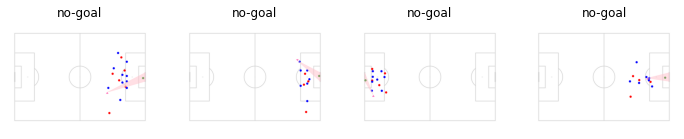

In [22]:
dls.show_batch(nrows=1, ncols=4)

In [23]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.628992,0.394818,0.134218,0.865782,03:03


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.384218,0.302522,0.097345,0.902655,03:58


Review the model

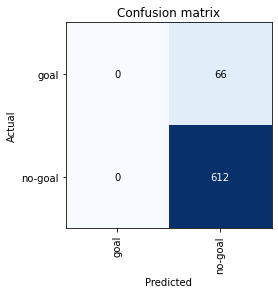

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Make some predictions on the test-data.

First, let's go through predicting a single image...

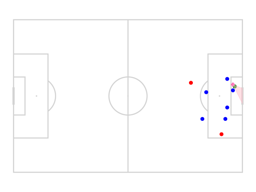

In [25]:
import PIL

# Load an image from the test data
example_img_path = Path('../data/processed/test/goal').ls()[0]
example_img = PILImage.create(example_img_path)

display(example_img.to_thumb(256, 256))

In [26]:
_, _, probs = learn.predict(example_img)

xg, _ = probs

print(f'xG: {float(xg)}')

xG: 0.11548550426959991


Load all test data

In [27]:
import json


def get_event_id(filepath):
    return filepath.stem


def is_goal(filepath):
    return filepath.parent.name == 'goal'


def predict_xg(filepath):
    img = PILImage.create(filepath)
    _, _, probs = learn.predict(img)
    xg, _ = probs
    return float(xg)


def get_statsbomb_xg(filepath):
    event_id = get_event_id(filepath)
    with open(f'../data/raw/{event_id}.json', 'r') as f:
        e = json.load(f)
    return e['shot']['statsbomb_xg']

In [28]:
def process_test_shot(filepath):
    return {
        'path': filepath,
        'id': get_event_id(filepath),
        'is_goal': is_goal(filepath),
        'xg': predict_xg(filepath),
        'sb_xg': get_statsbomb_xg(filepath)
    }


test_shots = Path('../data/processed/test/goal/').ls() + Path('../data/processed/test/no-goal/').ls()
shots_predicted = [process_test_shot(s) for s in test_shots]

In [29]:
import pandas as pd

predictions = pd.DataFrame(shots_predicted)

# Add inferred columns
predictions['diff'] = abs(predictions['sb_xg'] - predictions['xg'])

predictions

,path,id,is_goal,xg,sb_xg,diff
0,../data/processed/test/goal/d9c98a82-9e9e-42ff-adf2-4430b6ce62b2.png,d9c98a82-9e9e-42ff-adf2-4430b6ce62b2,True,0.115486,0.131717,0.016232
1,../data/processed/test/goal/ab097b1b-be53-47ca-b541-a4201bf1ecb4.png,ab097b1b-be53-47ca-b541-a4201bf1ecb4,True,0.046274,0.135544,0.089270
2,../data/processed/test/goal/ec46fa42-ad15-41c3-a636-98d1f1aef472.png,ec46fa42-ad15-41c3-a636-98d1f1aef472,True,0.088566,0.084931,0.003635
3,../data/processed/test/goal/aa3da20c-cf80-40b3-b89e-0f113ffa5ccb.png,aa3da20c-cf80-40b3-b89e-0f113ffa5ccb,True,0.153353,0.433190,0.279837
4,../data/processed/test/goal/3b9dea42-784d-49da-91d8-cd5a198104f0.png,3b9dea42-784d-49da-91d8-cd5a198104f0,True,0.173292,0.438073,0.264782
...,...,...,...,...,...,...
1011,../data/processed/test/no-goal/1629bafd-50b0-420c-8f07-70f5a7fb9eab.png,1629bafd-50b0-420c-8f07-70f5a7fb9eab,False,0.039603,0.086970,0.047367
1012,../data/processed/test/no-goal/e9d01a8c-3d96-4628-aa2f-b16551fb6183.png,e9d01a8c-3d96-4628-aa2f-b16551fb6183,False,0.113145,0.042855,0.070289
1013,../data/processed/test/no-goal/f396e4ca-3e47-4d81-8b7b-2404f29eb7f0.png,f396e4ca-3e47-4d81-8b7b-2404f29eb7f0,False,0.030810,0.055968,0.025158
1014,../data/processed/test/no-goal/55de3730-785a-40d5-87a2-7a6acffa8140.png,55de3730-785a-40d5-87a2-7a6acffa8140,False,0.081014,0.056676,0.024339


Compare to SB xG

In [30]:
# Compare overall error rate between SB and image xG
import numpy as np


def mse(pred, obs):
    return np.mean((obs - pred)**2)

print(mse(predictions['is_goal'].mean(), predictions['is_goal']))
print(mse(predictions['sb_xg'], predictions['is_goal']))
print(mse(predictions['xg'], predictions['is_goal']))

0.0957737227974456
0.07540024293882272
0.09353662796249816


Im-xG: 0.04
SB-xG: 0.82
Diff:  0.78


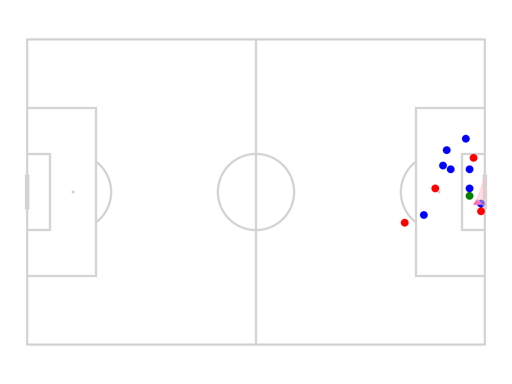

Im-xG: 0.06
SB-xG: 0.82
Diff:  0.76


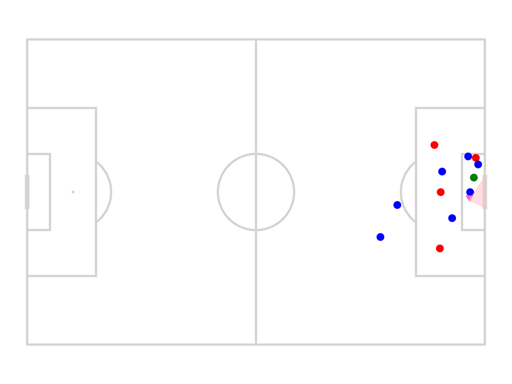

Im-xG: 0.19
SB-xG: 0.90
Diff:  0.71


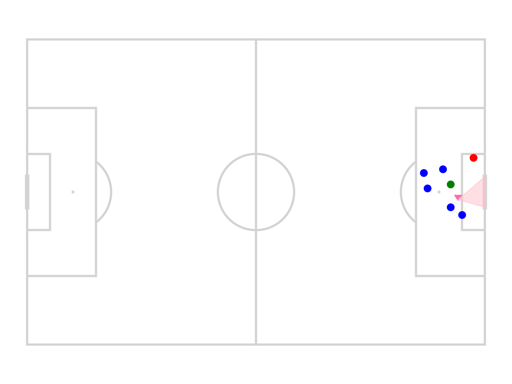

Im-xG: 0.11
SB-xG: 0.78
Diff:  0.67


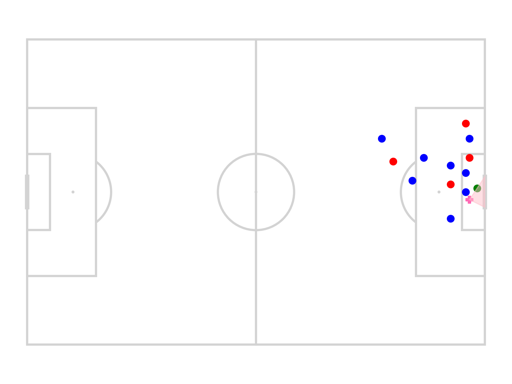

Im-xG: 0.05
SB-xG: 0.71
Diff:  0.66


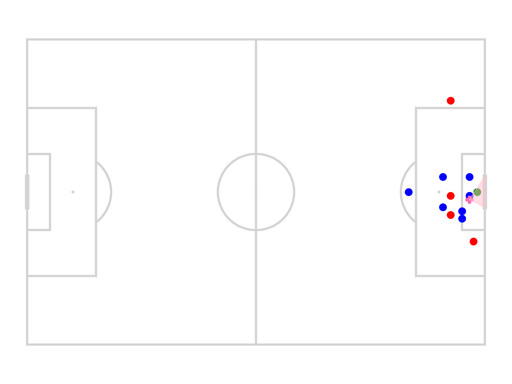

Im-xG: 0.15
SB-xG: 0.81
Diff:  0.66


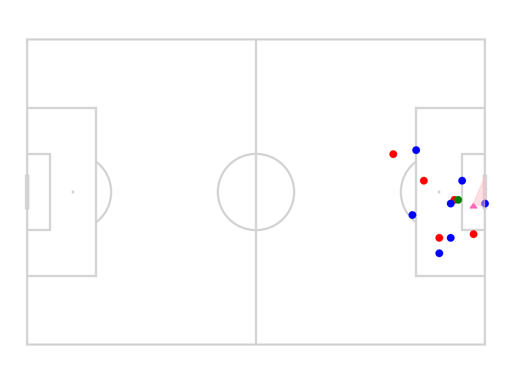

Im-xG: 0.06
SB-xG: 0.70
Diff:  0.65


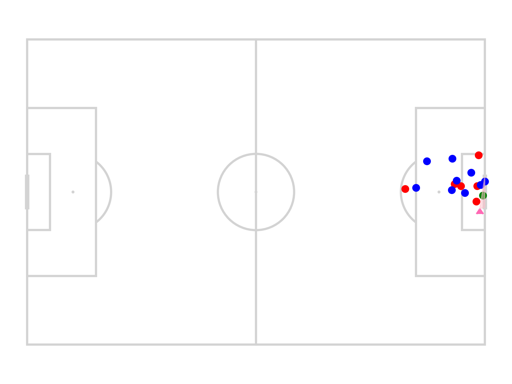

Im-xG: 0.13
SB-xG: 0.77
Diff:  0.64


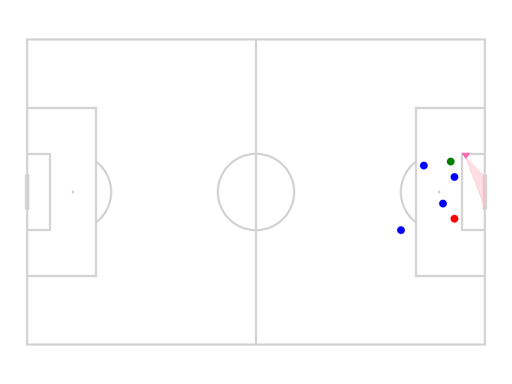

Im-xG: 0.04
SB-xG: 0.66
Diff:  0.63


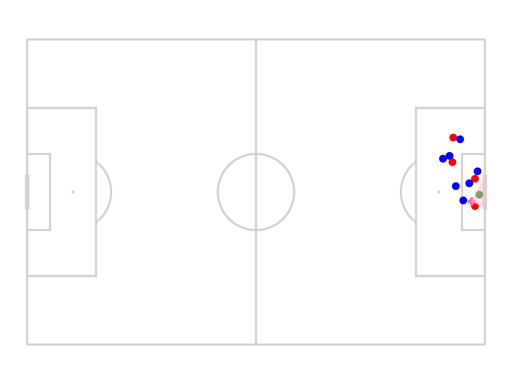

Im-xG: 0.05
SB-xG: 0.62
Diff:  0.58


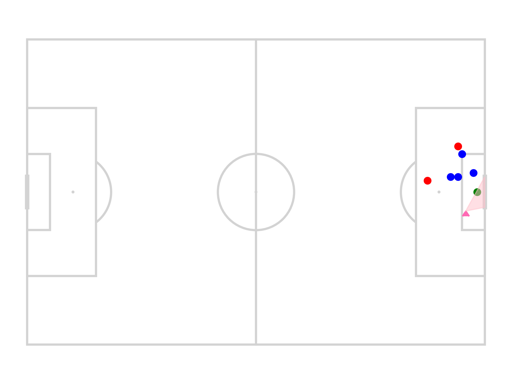

In [31]:
for _, p in predictions.sort_values(by='diff', ascending=False).head(10).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

Im-xG: 0.02
SB-xG: 0.02
Diff:  0.00


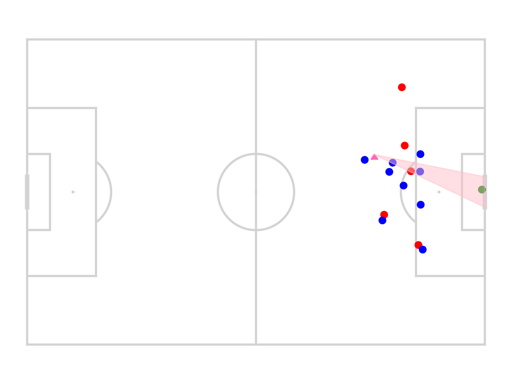

Im-xG: 0.02
SB-xG: 0.02
Diff:  0.00


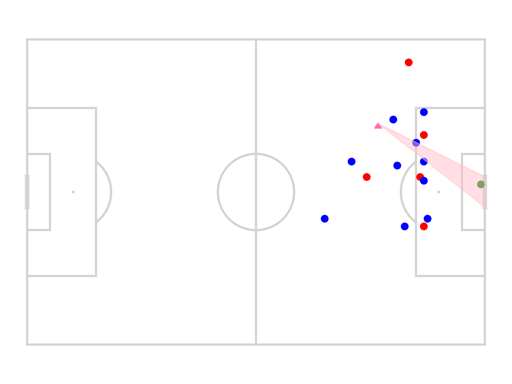

Im-xG: 0.13
SB-xG: 0.13
Diff:  0.00


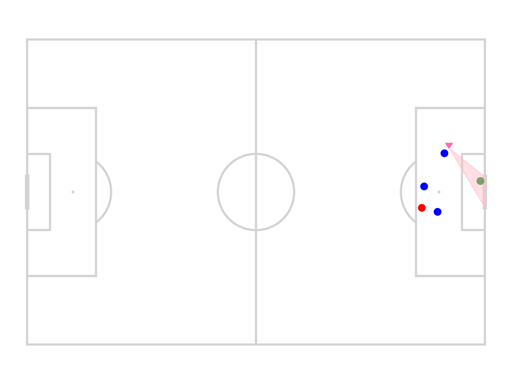

Im-xG: 0.02
SB-xG: 0.02
Diff:  0.00


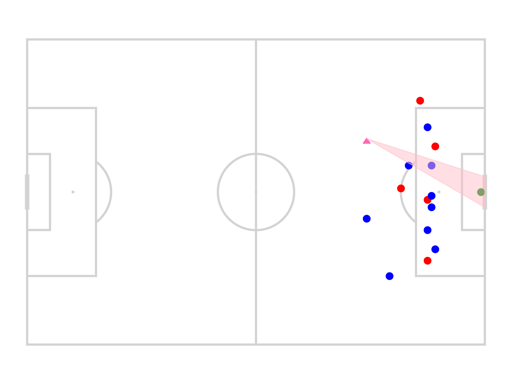

Im-xG: 0.03
SB-xG: 0.03
Diff:  0.00


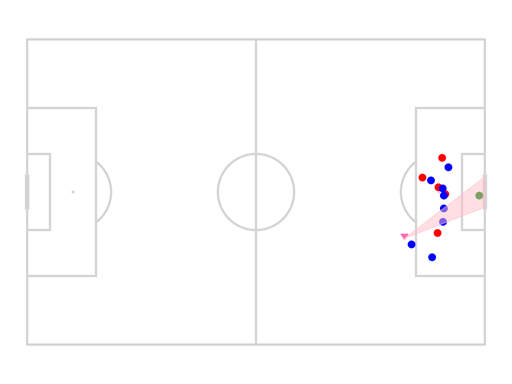

Im-xG: 0.05
SB-xG: 0.05
Diff:  0.00


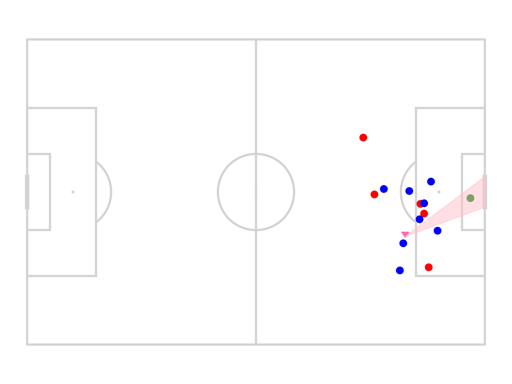

Im-xG: 0.06
SB-xG: 0.06
Diff:  0.00


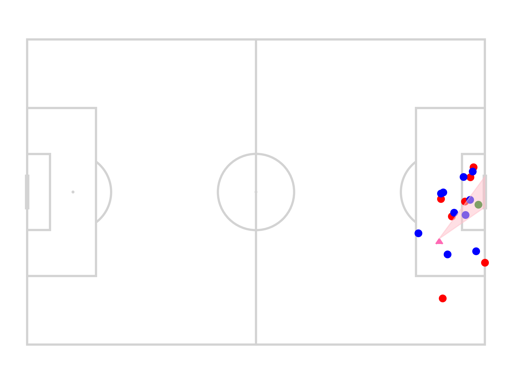

Im-xG: 0.03
SB-xG: 0.03
Diff:  0.00


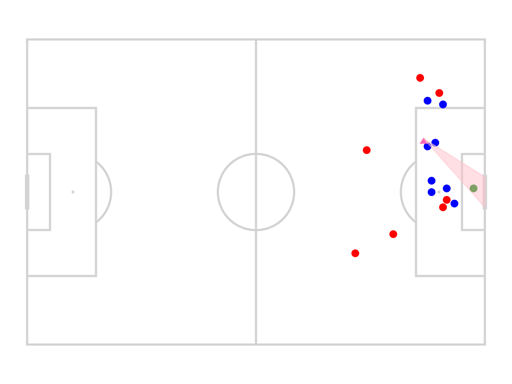

Im-xG: 0.02
SB-xG: 0.02
Diff:  0.00


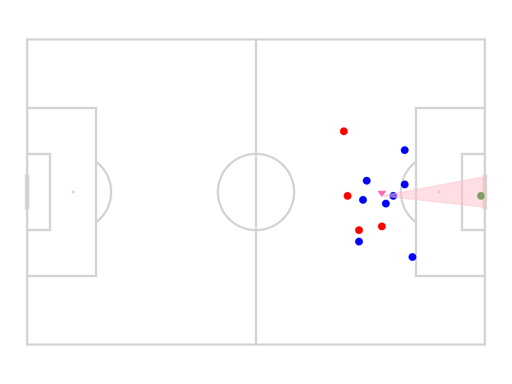

Im-xG: 0.03
SB-xG: 0.03
Diff:  0.00


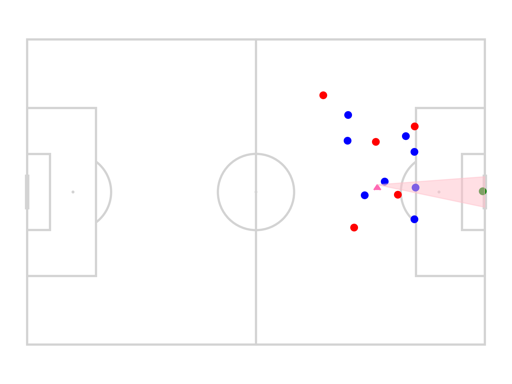

In [32]:
for _, p in predictions.sort_values(by='diff', ascending=True).head(10).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)